In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'ロジスティック回帰特徴量ミニマム'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '048'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

048_submission.csv 048


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', StandardScaler(), discrete_features),
            ('categorical', 'passthrough', categorical_features)
        ]
    )
    clf = LogisticRegression(class_weight='balanced',
                             random_state=SEED,
                             max_iter=1000,
                             n_jobs=-1)
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
for c in categorical_features:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

categorical_features_1hot = []
for c in categorical_features:
    categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
print(categorical_features_1hot)

features = discrete_features + categorical_features_1hot

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['S', 'O', 'totalPitchingCount', 'numRunners', 'B', 'inningNo']
['b1_1', 'b2_1', 'b3_1', 'batterID_0', 'batterID_2', 'batterID_5', 'batterID_9', 'batterID_11', 'batterID_12', 'batterID_15', 'batterID_18', 'batterID_19', 'batterID_21', 'batterID_22', 'batterID_26', 'batterID_27', 'batterID_28', 'batterID_29', 'batterID_31', 'batterID_34', 'batterID_36', 'batterID_37', 'batterID_39', 'batterID_42', 'batterID_45', 'batterID_47', 'batterID_50', 'batterID_55', 'batterID_56', 'batterID_58', 'batterID_60', 'batterID_67', 'batterID_70', 'batterID_72', 'batterID_73', 'batterID_75', 'batterID_80', 'batterID_82', 'batterID_84', 'batterID_85', 'batterID_87', 'batterID_89', 'batterID_91', 'batterID_98', 'batterID_102', 'batterID_103', 'batterID_105', 'batterID_106', 'batterID_111', 'batterID_112', 'batterID_114', 'batterID_117', 'batterID_118', 'b

In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features_1hot)
    clf.fit(X_train, y_train.values)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[1475  920  567  618  642  471   24  349]
 [ 489 1568  383  387  362  305   19  233]
 [ 254  330  757  354  352  199   11  136]
 [ 171  183  180  768  228   98    6   75]
 [  31   21   19   21  391   34    1   22]
 [   0    0    0    0    0  148    0    2]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[283 239 183 197 169 110   8  78]
 [156 267 108 132 113  88   8  64]
 [ 95  97 112 105  94  58   1  37]
 [ 52  64 100  84  56  46   3  22]
 [ 16  22  30  26  21  12   0   8]
 [  7   5   4   7   6   4   1   3]
 [  2   0   1   0   0   0   0   0]
 [  4   7   6   2   5   0   0   0]]

**********Confusion matrix for train set (Fold 2)**********
[[1545  863  603  614  621  436   25  359]
 [ 512 1518  388  378  370  302   20  258]
 [ 266  333  777  357  320  187   10  143]
 [ 171  175  190  761  226   91    9   86]
 [  20   21   1

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.314334,0.139805
std,0.002905,0.003994
min,0.311826,0.135876
25%,0.312157,0.137659
50%,0.313095,0.138642
75%,0.315941,0.140579
max,0.318649,0.146270


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,1,0,1
2,2,0,0,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.146745,0.152199,0.168948,0.080308,0.361077,0.044932,0.037655,0.008137,27446,1
1,0.096611,0.116136,0.544142,0.163449,0.057422,0.001846,0.018562,0.001831,113,1
2,0.160111,0.244940,0.426947,0.115878,0.031122,0.001038,0.017481,0.002482,4479,1
3,0.149300,0.219624,0.436897,0.149157,0.037583,0.001107,0.003649,0.002682,29080,1
4,0.313557,0.121427,0.253001,0.209511,0.067616,0.020094,0.007913,0.006882,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.241382,0.226988,0.206688,0.233114,0.060684,0.016683,0.003029,0.011433,24272,5
33804,0.127967,0.096254,0.259567,0.294873,0.167950,0.042630,0.001279,0.009479,29106,5
33805,0.081685,0.097800,0.344396,0.323928,0.104543,0.029159,0.000137,0.018351,20679,5
33806,0.248743,0.103385,0.253526,0.258250,0.128418,0.005917,0.000231,0.001530,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.729810,1.581671,0.860738,1.182923,0.472241,0.099730,0.000483,0.072405
1,1,0.776409,1.636755,0.597084,0.835519,0.077717,1.057248,0.001162,0.018106
2,2,0.175305,0.188442,0.582452,0.900900,2.682792,0.367430,0.005887,0.096791
3,3,1.500433,1.633947,0.497338,0.557941,0.469360,0.258451,0.003327,0.079203
4,4,0.880373,1.821743,0.269036,0.625202,1.378653,0.001936,0.000557,0.022499
...,...,...,...,...,...,...,...,...,...
33803,33803,1.756289,0.718316,0.900893,0.645597,0.824835,0.045219,0.002277,0.106574
33804,33804,1.475333,1.032760,0.738765,1.025674,0.623690,0.031212,0.001290,0.071276
33805,33805,1.516134,0.940508,0.482635,0.750733,0.529076,0.191887,0.005877,0.583150
33806,33806,0.264282,0.410134,0.857008,1.122989,1.189243,1.084803,0.006140,0.065399


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,4
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,4


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.237104
1    0.317410
2    0.091339
3    0.150881
4    0.103348
5    0.057176
6    0.003520
7    0.039221
Name: y, dtype: float64

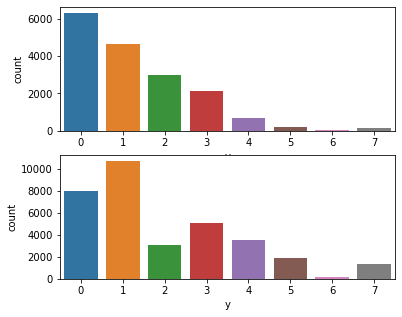

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.31433370386432535, 0.13980534731840158)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"048_submission.csv","Stratified-Kfold(K=5)","0.314334","0.139805","","ロジスティック回帰特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 11 ms


In [22]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [35]:
imp_df

""


In [34]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 117 ms


In [33]:
coef_df

,S,O,totalPitchingCount,numRunners,B,inningNo,b1_1,b2_1,b3_1,batterID_0,...,pitcherTeam_5,pitcherTeam_6,pitcherTeam_7,pitcherTeam_8,pitcherTeam_9,pitcherTeam_10,pitcherTeam_11,pitcherTeam_12,y,fold
0,-0.029826,0.086932,0.252188,-0.017027,-0.783327,0.026307,-0.160898,0.158487,-0.015405,0.052232,...,-0.181501,-0.015469,0.118563,0.358912,-0.225838,-0.217576,0.290387,-0.005631,0,1
1,-0.577234,0.013257,0.095057,-0.075746,-0.180538,0.003065,-0.132884,0.140466,-0.072064,0.252888,...,-0.173993,-0.022389,-0.134478,0.386773,-0.155054,-0.152958,0.376970,0.044560,1,1
2,0.299104,-0.069227,-0.134981,0.002602,-0.012667,0.011296,0.042125,0.059983,-0.104427,0.546712,...,0.003046,0.038469,0.036842,0.362418,-0.363560,0.073761,0.062358,-0.075732,2,1
3,0.038738,-0.133494,0.492172,0.049660,-0.319909,0.042799,0.072212,0.101814,-0.138905,-0.243479,...,-0.149009,0.101444,-0.248306,0.662390,-0.349364,-0.214855,0.624702,0.076088,3,1
4,0.227542,0.001309,0.274541,-0.079463,-0.176048,0.215521,0.015138,0.092872,-0.174906,0.501659,...,0.050720,-0.124681,-0.056789,0.146545,0.179271,0.029474,0.042218,-0.485519,4,1
5,0.285918,-0.145115,-0.171664,0.025268,0.284202,0.117684,-0.086375,-0.187756,0.291575,-0.656308,...,0.058637,-0.704806,0.609753,-0.594749,-0.384366,0.050164,-0.225961,0.607397,5,1
6,0.242906,0.515006,-1.291718,-0.104342,1.337405,-0.238956,0.103314,-0.287265,0.128380,-0.015077,...,0.943576,0.803634,-1.004917,-0.476966,0.577253,0.740894,-0.355232,0.156525,6,1
7,-0.487148,-0.268669,0.484406,0.199047,-0.149119,-0.177716,0.147368,-0.078601,0.085751,-0.438627,...,-0.551476,-0.076201,0.679334,-0.845322,0.721658,-0.308903,-0.815442,-0.317688,7,1
0,-0.128274,0.059942,0.303512,0.007152,-0.734264,-0.024075,-0.093191,0.073876,0.020478,0.216371,...,-0.351812,0.059423,0.118355,0.115677,-0.039375,-0.082556,0.376496,-0.016520,0,2
1,-0.687581,-0.007582,0.216372,-0.068832,-0.187387,-0.014782,-0.003880,-0.049761,-0.005641,0.082648,...,-0.238076,0.139343,-0.025716,0.149390,0.042684,0.064745,0.417103,0.034989,1,2
